In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_classif, f_regression

# Solution Key

Solutions for all checks for understanding can be found in the `feature_selection_and_grid_search_solutions.ipynb` notebook.

# Overall Guide for Today

Today introduces two related but distinct concepts:

- How to optimize what features go into your model (feature selection)
- How to optimize what hyperparameters you use in your model (hyperparameter optimization)

In other words, we are looking to maximize the predictive power of our models by selecting good features and good values for hyperparameters. 

# Feature Selection

Feature selection is the process of deciding what features should (or should not!) go into a model. We'll begin by discussing some general techniques and then go into some automated techniques that `scikit-learn` offers us.

## General Techniques

- Domain Knowledge
- Bivariate Correlation (Correlation Matrix / Heatmap)
- Regularization

## Domain Knowledge

In the ideal case, we will be working with data that has a smaller number of features in a domain that we know well. This domain  knowledge will help us choose features for our model that may be appropriate or predictive. 

Alternatively, we may be in a field where certain features are expected to be included in a given regression. One example of this is political polling, where age, gender, race, and past voting behavior are not only predictive and useful features, but models that did **not** contain those features would seem out-of-place and might be highly scrutinized. 

However, it is typically rare that we will be masters of domain knowledge or that we will have access to all of the features we would like to include. 

How do we obtain domain knowledge? There are a couple of options:

1. Independent and external research
2. For similar models, see what other researchers / data scientists have included in the past
3. In industry, talk to individuals who are consumers or generators of that data (such as talking to fraud analysts when making a model to detect fraud)

One downside to using domain knowledge is that developing this domain knowledge is a time-consuming endeavor. We as data scientists may not have the time to develop or refresh that knowledge!

### Check for Understanding (5 Minutes)

With a partner or a small group, discuss the following:
1. What is a common question that has a predictive element in a field where you have worked in the past?
  > For example, if I had worked in the political campaigning field, I might say that a common predictive question is "Will my candidate or my candidate's opponent win in the next election?"
2. Using your domain knowledge, discuss features that you would likely include in this model. 

We will call on a random city at the end of 5 minutes to come on mic to discuss their findings. 

```
Instructor answer:

I worked in predictive modeling for fraudulent applications for two years. One common predictive question was "How likely is it that applicant X seeks to defraud their customers?" Typical features were:

- Age of business
- State / Country of licensure
- Type of business
- Website quality 

We included many other features, but knowing that kind of domain knowledge helped us zero in on features that were immediately helpful. We developed that domain by speaking frequently with domain experts
```

## Correlations

Another useful technique (though by no means a silver bullet!) is to look at the correlations across your dataset, including:

- Is a given feature correlated with your target?
- How much correlation occurs between a given feature and all other features?

One of the easiest ways to display this information is via a correlation matrix (and the easiest way to display _that_ is to use a heatmap.

We will use the Boston housing prices dataset as an example. The features present in the housing prices dataset are as follows:

- CRIM     per capita crime rate by town
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- RM       average number of rooms per dwelling
- AGE      proportion of owner-occupied units built prior to 1940
- DIS      weighted distances to five Boston employment centres
- RAD      index of accessibility to radial highways
- TAX      full-value property-tax rate per $10,000
- PTRATIO  pupil-teacher ratio by town
- B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT    % lower status of the population

with MEDV being the target column (median housing price per housing tract)

We begin by importing the `datasets/boston.csv` into Pandas and printing the results of the `.corr()` method.

`.corr()` provides a correlation table across each of the features (defaulting to the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) -- here, -1 means perfect negative linear correlation, 0 means no correlation whatsoever, and +1 means perfect positive linear correlation). 

In [2]:
df = pd.read_csv('datasets/boston.csv')
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220,-0.385832
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


### Check for Understanding (5 minutes) 

As a pair or small group, use the correlation table that we created above to answer the following questions:

1. Which feature has the strongest positive correlation with `MEDV`?
2. Which feature has the strongest negative correlation with `MEDV`?
3. What feature is most strongly correlated with _another_ feature (that is not `MEDV`)?
4. Using this table, pick three features that you might include in a model to predict `MEDV`. Why did you pick those features?

We will call on a random city at the end of 5 minutes to come on mic to discuss their findings.

```
Instructor answer:

1. Outside of MEDV (which is itself), the feature with the strongest positive correlation with MEDV is RM at 0.69
2. The feature with the strongest negative correlation with MEDV is LSTAT at -0.73

Note: I used the following code to answer questions 1 and 2

df.corr()['MEDV'].sort_values(ascending=True)

which sorts the correlations for the MEDV feature from smallest to largest

3. The largest pairs is TAX and RAD, which have a correlation of 0.91

Note: I used the following code to answer question 3

for col in df.corr().columns:
    print(col)
    correlations = df.corr()[col].apply(lambda x: abs(x)).sort_values(ascending=False).head(2)
    print(correlations, '\n')

4. I would pick LSTAT, RM, and PTRATIO as my features because they have the strongest correlation of all features (either positive or negative)

Note: I used the following code to answer question 4

df.corr()['MEDV'].apply(lambda x: abs(x)).sort_values(ascending=False).head(4)
```

However, for many columns it may be very difficult to read (or keep track) of all of those values! A heatmap can help us visually see areas that are most interesting to us:

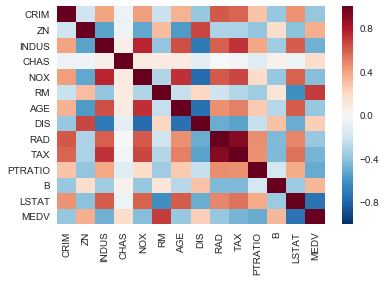

In [3]:
sns.heatmap(df.corr())

In this case, we would look along the `MEDV` column / row for strongly colored squares for features that would be useful to include.

_Note_: One thing to remember with this approach is that we are only considering bivariate correlations -- in other words, we are not looking at how other features correlate with each other as well. High correlation can be predictive, but can also be a poor choice for a model because of the following reasons:

1. The feature may be highly correlated because it's a transformation of the target column itself 
2. The feature may be highly correlated with other features that will be included leading the impact of all of both to be diminished in a parametric model. 

In other words, this is a good technique to investigate candidates for inclusion, but it is not appropriate to use just this technique.

If you want to dig deeper into how features relate to each other, Seaborn's `pairplot` feature is a useful tool, but can take time to process each of the internal graphs

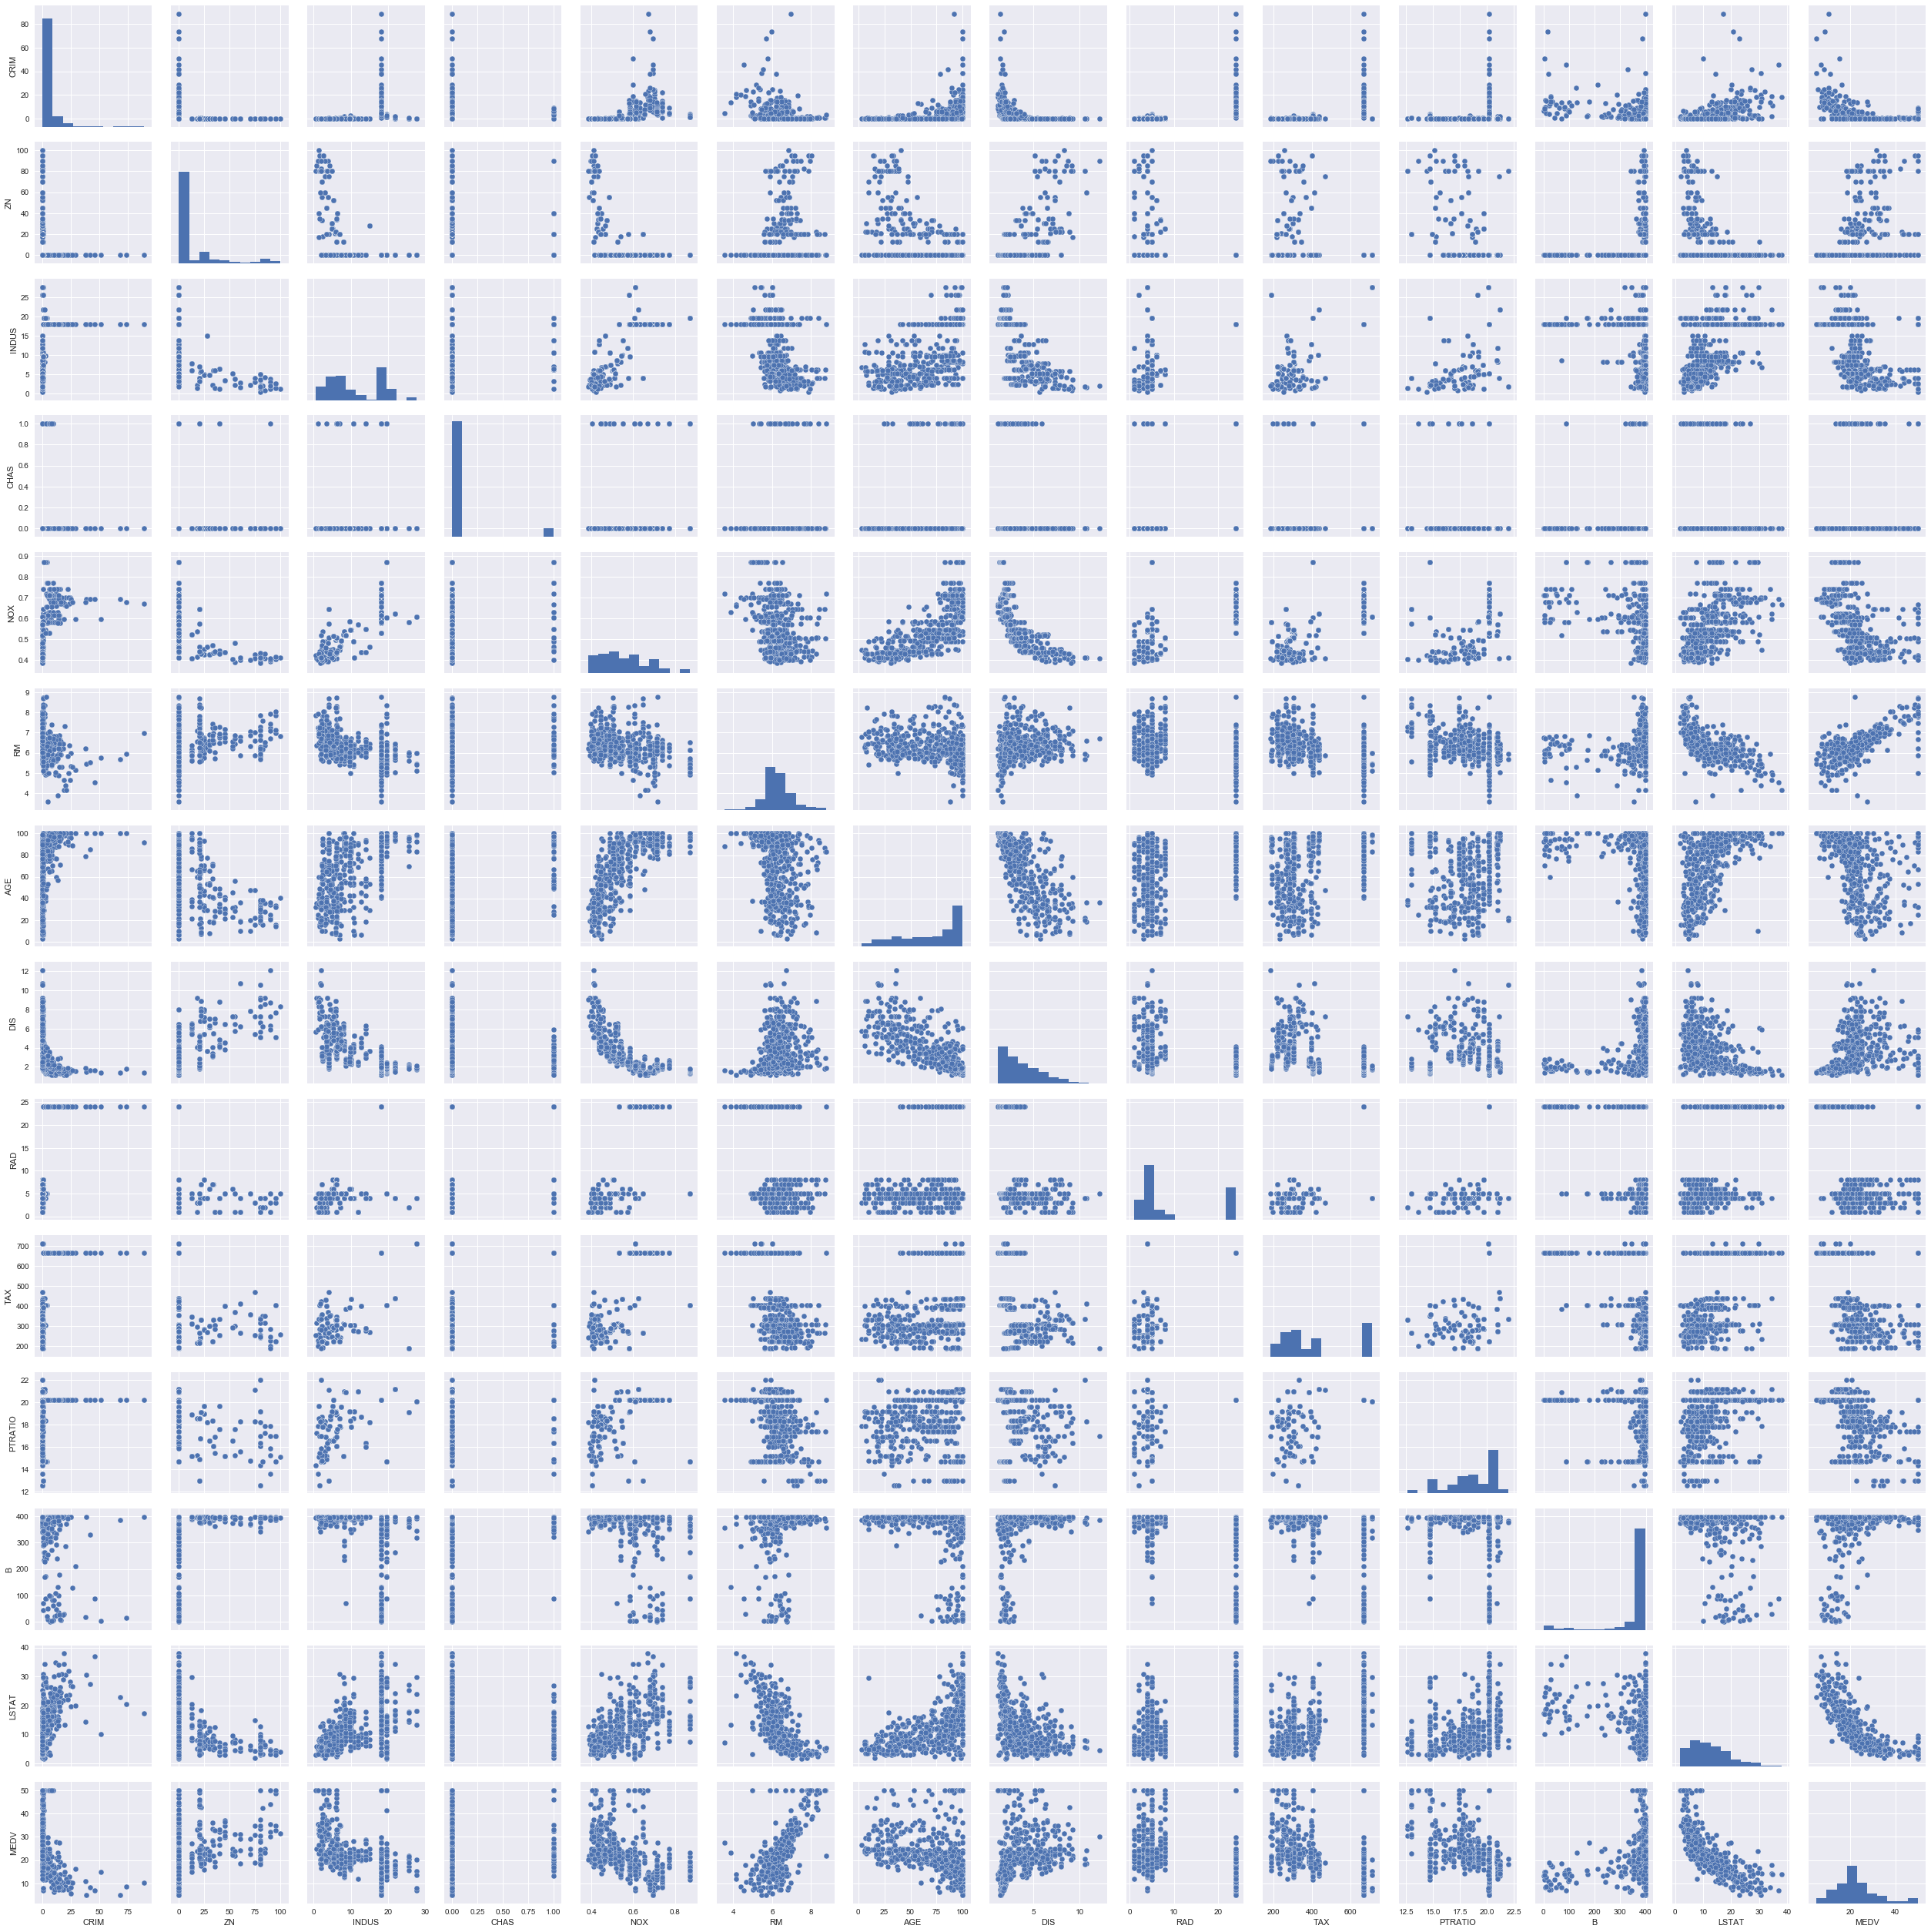

In [4]:
sns.pairplot(df)

### Check for Understanding (10 Minutes)

For this check for understanding, we will import a new dataframe on wine quality. This dataset has the following features that are predictive of wine quality:

- Alcohol
- Malic acid
- Ash
- Alcalinity of ash  
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline

as well as a target feature denoting which quality of wine the bottle in question is (one of three classes)

In [5]:
wine = pd.read_csv('datasets/wine.csv')
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In this check for understanding, please work individually to do the following:

1. Use the Pandas `.get_dummies()` method to create dummy columns for the three different classes of wine in the dataframe
2. Use the Pandas `.corr()` method and the Seaborn `.heatmap()` method to visually identify features that are highly correlated. What features would you include in a model to predict whether a wine is class 0 or not?
3. Create a new dataframe with just the features you identified in step 2. Use the Seaborn `.pairplot()` method to look at pairwise information **just for the features you have identified in question 2**. Describe what, if any, relationship those features have. 

There is solution code available for this check for understanding, but please try to use all of your coding skills to date to quickly tackle the three prompts above before checking your work. This task is designed to check your understanding of some of the skills we have learned in this task as well as Pandas methods and indexing -- we are not expecting clean or perfect code here, but to give you a chance to try to identify how _you_ would approach this problem if faced with it during a code challenge / on the job. In other words, making it work is more of a priority than clean or efficient code at this point.

In [6]:
quality_dummies = pd.get_dummies(wine['quality'], prefix='quality')
wine = wine.join(quality_dummies)

```
Instructor answer:

Based on the intensity of color in the heatmap, I would likely include proline, flavanoids, total_phenols, and alcohol. I would not include quality, quality_1, or quality_2 (despite high correlation) because that would be predicting the target with the target)
```

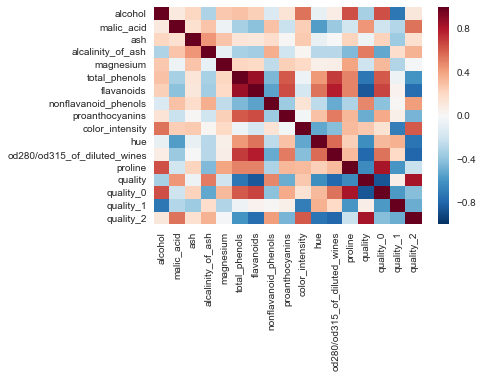

In [7]:
sns.heatmap(wine.corr())
plt.show()

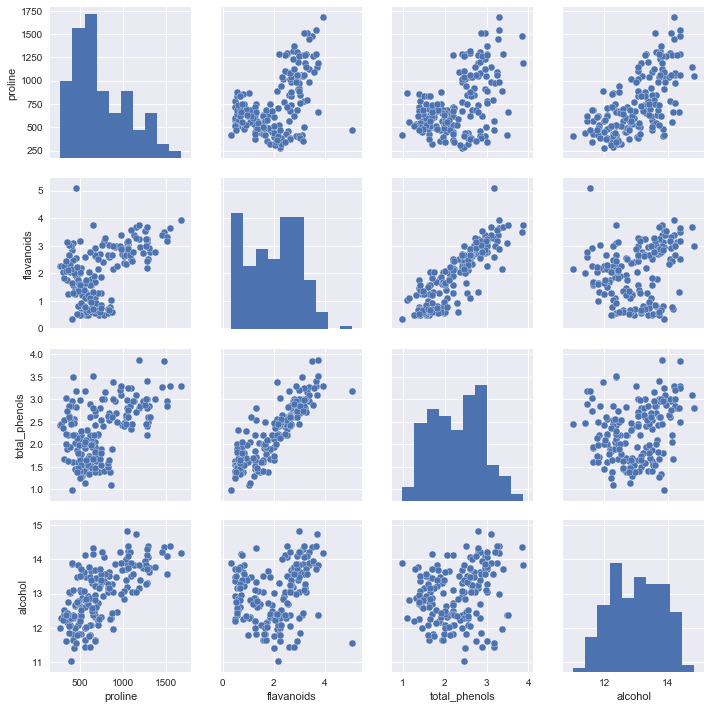

In [8]:
features = wine[['proline', 'flavanoids', 
               'total_phenols', 'alcohol']].copy()

sns.pairplot(features)

```
Instructor answer:

It looks like alcohol has very little relationship with everything else, though proline seems to have a strong relationship with the other features. total_phenols and flavanoids are highly correlated as well
```

## Using regularization for feature selection

Regularization, specifically Lasso / L1 regularization (least absolute shrinkage and selection operator), is another way to identify features that we may want to keep or remove. 

What we will do in this case is fit a regression model (of the appropriate type) using Lasso regularization. Parameters that are near 0 or reduced to 0 are then considered good candidates to be dropped. These are good candidates because the model is a _stronger model_ if they have a small or near-zero coefficient when faced with the regularization penalty.

**Note**: We will not consider here what a good regularization penalty might be (that's for later on in this section), but will instead stick with the default penalty

### Exploring Lasso regularization for feature selection (Regression models)

In this example, we will use the `Lasso` object to fit a model in our Boston dataset and identify which features are good candidates for removal from the model. First, to refresh our memory, the first five rows of the Boston dataset are the following:

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Next, let's split off the features into a variable called `X` and the target column into a variable called `y`.

**Note**: If we were creating a model from scratch, we would want to train-test split before this step. In this section however, we are engineering or selecting features to go into the model and are using what comes out of this model to inform what we will actually make down the line. Cross-validation is not _strictly_ necessary at this step

In [10]:
X = df[[col for col in df.columns if col !='MEDV']].copy()
y = df[['MEDV']].copy()

Next, we will fit a `Lasso` model predicting `y` with all of the features in `X`:

In [11]:
lasso = Lasso()
lasso.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Next, let's look at the coefficients and see which ones have been driven towards zero. These are good candidates to be removed from the model:

In [12]:
for i, col in enumerate(df.columns[:-1]):
    print(col, lasso.coef_[i])

CRIM -0.0634225454858
ZN 0.0491686686903
INDUS -0.0
CHAS 0.0
NOX -0.0
RM 0.94678566696
AGE 0.0209273679344
DIS -0.669008638555
RAD 0.264175006084
TAX -0.0152091514001
PTRATIO -0.723199013522
B 0.0082911659532
LSTAT -0.761432957426


This suggests that at the very least, `INDUS`, `CHAS`, and `NOX` would be good candidates to remove, and a strong case could be made for `B`, `TAX`, `CRIM`, `ZN`, and `AGE` as well. 

Our next step would be to remove those features and create a model with just those characteristics. Here we will use the regular `LinearRegression()` object, but you could continue to use regularization as well. 

We will begin by creating a new `X` containing just the columns `LSTAT`, `PTRATIO`, `RAD`, `DIS`, and `RM`. Then we will use `cross_val_score` to compare the results from a model with all features as compared to a model with just these features (that we have determined via feature selection):

In [13]:
selected_X = df[['LSTAT', 'PTRATIO', 'RAD', 'DIS', 'RM']].copy()
lr = LinearRegression()

print('All features')
scores = cross_val_score(lr, X, y)
print(scores, '\n', 'Mean: ', scores.mean())

print('Feature Selection via Regularization')
scores = cross_val_score(lr, selected_X, y)
print(scores, '\n', 'Mean: ', scores.mean())

All features
[ 0.5828011   0.53193819 -5.85104986] 
 Mean:  -1.57877018572
Feature Selection via Regularization
[ 0.62566702  0.47128894 -0.20123162] 
 Mean:  0.298574780062


Feature selection has helped us choose features that are more applicable and are less likely to lead us towards overfitting!

### Check for Understanding (Until end of break)

This check for understanding will apply feature selection via regularization to a classification problem instead of a regression problem.

Please use the wine dataframe for this example. As a reminder, the first five rows of that dataframe are the following:

In [14]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality,quality_0,quality_1,quality_2
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,1,0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,1,0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,1,0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,1,0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1,0,0


In this check for understanding, we will predict whether or not a wine is quality class 0. Individually, please try to do the following:

1. Fit a Lasso (L1) Logistic Regression to all of the features in `wine` **that are not the target column or derivations of the target column such as dummy variables**. Use the default value for regularization.
  > You can find information on regularization in the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) documentation. Remember that this while Linear Regression has a separate `Lasso` class, Logistic Regression does not!
2. Print out each coefficient and the column associated with it. What features are good candidates for removal? Why?
  > If you run into difficulty printing the coefficients, check the shape of what is returned in the `.coef_` attribute. Make any necessary changes to code that you may need.
3. Create a new dataframe, dropping the features that you believe appropriate to drop. 
4. Use `cross_val_score()` to compare cross-validated results for a Logistic Regression fit on all of your features versus a Logistic Regression fit on only the features you have selected. Which does better?
5. **Bonus**: We have used the parameters and how close they are to zero as a way to decide whether or not to keep them. The scale of the variables might have an impact in whether or not that is useful! Why or why not?

There is solution code available for this check for understanding, but please try to use all of your coding skills to date to quickly tackle the prompts above before checking your work. This task is designed to check your understanding of some of the skills we have learned in this task as well as Pandas methods and indexing -- we are not expecting clean or perfect code here, but to give you a chance to try to identify how you would approach this problem if faced with it during a code challenge / on the job. In other words, making it work is more of a priority than clean or efficient code at this point.

In [15]:
# CfU 1

y = wine['quality_0'].copy()
X = wine[[col for col in wine if 'quality' not in col]].copy()

logreg = LogisticRegression(penalty='l1')
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# CfU 2

for i, col in enumerate([col for col in wine if 'quality' not in col]):
    print(col, logreg.coef_[0, i])

alcohol -0.490327554287
malic_acid 0.679872390552
ash 1.3025888678
alcalinity_of_ash -0.630870582496
magnesium -0.0356525717133
total_phenols 0.0
flavanoids 1.56633368861
nonflavanoid_phenols 0.0
proanthocyanins 0.0
color_intensity -0.0217146324088
hue 0.0
od280/od315_of_diluted_wines 0.353809224528
proline 0.0158422889725


```
Instructor answer:

Based on this, I will start by dropping the columns that have been zeroed out by Lasso (total_phenols, nonflavanoid_phenols, proanthocyanins, and hue)
```

In [17]:
# CfU 3

all_cols = [col for col in wine if 'quality' not in col]
drop_columns = ['total_phenols', 'nonflavanoid_phenols',
               'proanthocyanins', 'hue']
selected_X = wine[[col for col in all_cols if col not in drop_columns]].copy()

In [18]:
# CfU 4

print('All features')
scores = cross_val_score(logreg, X, y)
print(scores, '\n', 'Mean: ', scores.mean())

print('Feature Selection via Regularization')
scores = cross_val_score(logreg, selected_X, y)
print(scores, '\n', 'Mean: ', scores.mean())

All features
[ 0.86666667  0.96666667  0.98275862] 
 Mean:  0.938697318008
Feature Selection via Regularization
[ 0.85        0.96666667  0.98275862] 
 Mean:  0.933141762452


```
Instructor answer:

The selected X's do better, but only by a small amount. We already have a dataset that predicts exceptionally well!)
```

```
Instructor answer for **Bonus** question:

The size of the parameter (beta coefficient) and the scale of the data are related -- if we had two competing models, one where the predictive feature we were using was in cents and another where it was in dollars, we would expect a similar coefficient but a much smaller value for the data scaled in cents (because the one-unit change there covers a smaller movement over the distribution than a one-unit change in dollars).

This means that the coefficients that are near-zero but not zeroed out may mean one of two things:

1. The coefficient only adds a small amount of predictive power and so can be safely thrown out
2. The coefficient does add predictive power, but because of the scale of the data, it looks like it is near-zero (and is not predictive).

This can be solved by standardizing your columns before you use regularization for feature selection in the code below. What we see here is color_intensity and magneisum, which were very close to zero, are now zeroed out as well. Proline, however, which was very close to zero with the non-standardized coefficients, is now much stronger.

While it's typically a better practice to use standardized coefficients here for feature selection, we're only using this tool along with many others to help **inform** what features we should include. For ease of instruction, we've shown code with non-standardized data, but despite which version you use, this should be one of many tools for you to use. 
```

In [19]:
# CfU Bonus Question

ss = StandardScaler()
ss.fit(X)
standard_X = ss.transform(X)

logreg = LogisticRegression(penalty='l1')
logreg.fit(standard_X, y)

for i, col in enumerate([col for col in wine if 'quality' not in col]):
    print(col, logreg.coef_[0, i])
    
# CfU 3

drop_columns = ['total_phenols', 'nonflavanoid_phenols',
               'proanthocyanins', 'hue', 'color_intensity', 'magnesium']
selected_X = wine[[col for col in all_cols if col not in drop_columns]].copy()
ss_selected = StandardScaler()
ss_selected.fit(selected_X)
standard_selected_X = ss_selected.transform(selected_X)
    
print('All features standardized')
scores = cross_val_score(logreg, standard_X, y)
print(scores, '\n', 'Mean: ', scores.mean())

print('Feature Selection via Regularization with standardized data')
scores = cross_val_score(logreg, standard_selected_X, y)
print(scores, '\n', 'Mean: ', scores.mean())

alcohol 1.51028928894
malic_acid 0.254503716363
ash 0.961455103399
alcalinity_of_ash -1.47496890334
magnesium 0.0
total_phenols 0.0
flavanoids 0.913415205214
nonflavanoid_phenols 0.0
proanthocyanins 0.0
color_intensity 0.0
hue 0.0
od280/od315_of_diluted_wines 1.18170337504
proline 2.46856062177
All features standardized
[ 0.91666667  1.          0.93103448] 
 Mean:  0.949233716475
Feature Selection via Regularization with standardized data
[ 0.91666667  1.          0.96551724] 
 Mean:  0.960727969349


## Automatic Feature Selection with [Recursive Feature Elimination](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

Scikit-learn offers us a few great options for automatically determining which features should be included in a model. 


The first technique that we will learn about is [Recursive Feature Elimination](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). Recursive Feature Elimination uses a **bottom-up** approach to feature selection: it will fit successive versions of a model, starting with all of the features. Each new version of a model will drop the least informative or least useful feature until we end with some set number of features that we want to keep. 

#### `RFE` object

The technique we'll learn about today is `RFE`, though there are several options in sklearn's [`feature_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) module. `RFE` takes in the following arguments when instantiated:

- `estimator`: required argument, which model type you want to use to eliminate features
- `n_features_to_select`: optional keyword argument. This details how many features you want to have at the end of the elimination. It defaults to `None` which is half the features, rounded down.
- `step`: optional keyword argument. This details how many features you want to eliminate in each pass.
- `verbose`: set this to a value greater than 0 if you want detailed messages to print out during the fitting process

Code snippet:

```python
estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector.fit(X, y)
```

**Note**: It will only work if your estimator has a `.coef_` or `.feature_importances_` attribute, as it will use the size of these parameters to determine which features stay or go.

**Bonus question for thought**: why would `KNeighborsClassifier` _not_ provide a `.coef_` or `.feature_importances_` attribute? Would it make sense to ask what the role of a specific feature is in `KNeighborsClassifier`? Why or why not?

#### Example using `LinearRegression`

Let's use the Boston dataset and RFE to pick the top three features for a Linear Regression estimating the Median Housing Price (`MEDV`). As a reminder, the first five rows of this dataset are the following:

In [20]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


First, let's split up our dataset into our features (`X`) and our target column (`y`):

In [21]:
X = df[[col for col in df.columns if col != 'MEDV']].copy()
y = df['MEDV']

Next, we will instatiate our estimator (`LinearRegression()`) and the recursive feature elimination object (`RFE()`). We'll pass the estimator to `RFE()` as well as the number of desired columns at the end (`3`) and increase the verbosity so we can see the library at work.

In [22]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=3, verbose=2)

Next, we fit `rfe` to our `X` and `y` datasets:

In [23]:
rfe.fit(X, y)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=3, step=1, verbose=2)

We will want to see which features were ultimately selected in this process:

In [24]:
for i, col in enumerate([col for col in df.columns if col != 'MEDV']):
    if rfe.support_[i] == True:
        print(col, 'selected for model')

CHAS selected for model
NOX selected for model
RM selected for model


If we wanted to have a new dataframe with just those columns, the output of `rfe.support_` acts like a mask on those columns:

In [25]:
df.iloc[:, rfe.support_].head()

,CHAS,NOX,RM
0,0.0,0.538,6.575
1,0.0,0.469,6.421
2,0.0,0.469,7.185
3,0.0,0.458,6.998
4,0.0,0.458,7.147


We can then compare how well this performs compared to all columns:

In [26]:
print('All features')
scores = cross_val_score(lr, X, y)
print(scores, '\n', 'Mean: ', scores.mean())

selected_xs = df.iloc[:, rfe.support_].copy()

print('Feature Selection via RFE (3 columns)')
scores = cross_val_score(lr, selected_xs, y)
print(scores, '\n', 'Mean: ', scores.mean())

All features
[ 0.5828011   0.53193819 -5.85104986] 
 Mean:  -1.57877018572
Feature Selection via RFE (3 columns)
[ 0.50048769  0.14517779 -0.665559  ] 
 Mean:  -0.0066311743671


While our new model is not **great**, it is an improvement on the model using all features. This is a case where we may want to increase the number of features we include (i.e., maybe 5 or 10 may be better than 3)

## Check For Understanding (15 Minutes)

We will use the wine dataset for this Check for Understanding, using the class for quality=0 or not as our target. As a reminder, the first five rows of the wine dataset are as follows:

In [27]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality,quality_0,quality_1,quality_2
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,1,0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,1,0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,1,0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,1,0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1,0,0


Individually, please complete the following tasks:

1. Instantiate a logistic regression object and a new RFE object. Set the `n_features_to_select` keyword argument in the RFE to 5 features and the verbose setting to 2.
2. Fit the RFE object to all of the Xs in wine **that are not related to the quality (your target)**
3. Print out which features RFE has selected to keep
4. Using the `rfe.support_` attribute, create a dataframe that has just those columns (see previous example code for the linear regression part to help)
5. Use `cross_val_score()` to compare a logistic regression with all of your features versus those selected by rfe. Which model performs better? Are you surprised by your findings?
6. Try using `StandardScaler` to scale your features before you fit your RFE object. Were different columns selected? Do you find a difference in model performance? Why do you think this is the case?

There is solution code available for this check for understanding, but please try to use all of your coding skills to date to quickly tackle the prompts above before checking your work. This task is designed to check your understanding of some of the skills we have learned in this task as well as Pandas methods and indexing -- we are not expecting clean or perfect code here, but to give you a chance to try to identify how _you_ would approach this problem if faced with it during a code challenge / on the job. In other words, making it work is more of a priority than clean or efficient code at this point.

In [28]:
# CfU 1

logreg = LogisticRegression()
rfe_log = RFE(logreg, n_features_to_select=5, verbose=2)

In [29]:
# CfU 2

non_quality_cols = [col for col in wine.columns if 'quality' not in col]
X = wine[non_quality_cols].copy()
y = wine['quality_0'].copy()

rfe_log.fit(X, y)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=5, step=1, verbose=2)

In [30]:
# CfU 3

for i, col in enumerate(non_quality_cols):
    if rfe_log.support_[i] == True:
        print(col, 'selected for model')

ash selected for model
alcalinity_of_ash selected for model
flavanoids selected for model
color_intensity selected for model
od280/od315_of_diluted_wines selected for model


In [31]:
# CfU 4

selected_features = wine.iloc[:, rfe_log.support_]
selected_features.head()

,ash,alcalinity_of_ash,flavanoids,color_intensity,od280/od315_of_diluted_wines
0,2.43,15.6,3.06,5.64,3.92
1,2.14,11.2,2.76,4.38,3.40
2,2.67,18.6,3.24,5.68,3.17
3,2.50,16.8,3.49,7.80,3.45
4,2.87,21.0,2.69,4.32,2.93


In [32]:
# CfU 5

print('All features')
scores = cross_val_score(logreg, X, y)
print(scores, '\n', 'Mean: ', scores.mean())

selected_xs = selected_features.copy()

print('Feature Selection via RFE')
scores = cross_val_score(logreg, selected_xs, y)
print(scores, '\n', 'Mean: ', scores.mean())

All features
[ 0.86666667  0.96666667  0.96551724] 
 Mean:  0.932950191571
Feature Selection via RFE
[ 0.83333333  0.88333333  0.79310345] 
 Mean:  0.836590038314


```
Instructor answer: 

In this case, the features selected by RFE did not perform better than including all of the features. This may be because of the bottom-up selection process -- a feature might have a small coefficient but high predictive power. Standardizing our features might be important here.
```

In [33]:
# CfU 6

ss = StandardScaler()
ss.fit(X)
standard_X = ss.transform(X)

rfe_scaled = RFE(logreg, n_features_to_select=5, verbose=2)
rfe_scaled.fit(standard_X, y)

print('\n')

for i, col in enumerate(non_quality_cols):
    if rfe_scaled.support_[i] == True:
        print(col, 'selected for model')

print('\n')

selected_features = wine.iloc[:, rfe_scaled.support_]

print('All standardized features')
scores = cross_val_score(logreg, standard_X, y)
print(scores, '\n', 'Mean: ', scores.mean(),'\n')

selected_xs = selected_features.copy()

print('Feature Selection via RFE')
scores = cross_val_score(logreg, selected_xs, y)
print(scores, '\n', 'Mean: ', scores.mean())

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


alcohol selected for model
ash selected for model
alcalinity_of_ash selected for model
od280/od315_of_diluted_wines selected for model
proline selected for model


All standardized features
[ 0.88333333  1.          0.87931034] 
 Mean:  0.920881226054 

Feature Selection via RFE
[ 0.91666667  0.93333333  0.98275862] 
 Mean:  0.944252873563


```
Instructor answer:

In this case we did see a change of features: alcohol and proline were chosen over flavanoids and color_intensity. This did have an improvement in the cross-validated scores of our models, increasing the predictive power by 0.02 points. 
```

### Standardizing Features

While we have not directly addressed it, you should have noticed in the RFE section and, potentially earlier in the Regularization section, that these techniques worked better when the features were standardized **before** we used these techniques. 

The intuitive understanding as to why that's the case is as follows:

> In both cases, we're using the coefficient themselves to determine whether or not they should stay in the model. A coefficient might be smaller because of the scale of the variable **as well as** its relative importance or usefulness. Standardizing the features removes the role of the scale of the data in how big or small a coefficient is _at the cost of_ direct interpretation of that coefficient.

## Automatic Feature Selection with [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

The second technique that we will learn about is [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest). 

`SelectKBest` is a **top-down** form of feature selection: it will look at all of the features present in a model at once, use some sort of scoring function to determine which features (out of all of them) are best, and keep only those. 

The best way to contrast this to `RFE` is as follows:
- `RFE`: drops the worst loser with each successive pass
- `SelectKBest`: keeps **only** the _k_-best winners and throws everything else

In other words, if there are features that are less useful **when another feature is present**, `RFE` may catch that dynamic and `SelectKBest` may not. Because we won't know what is the best technique _a priori_, we will typically try many options to see what the best is.

#### `SelectKBest` object

`SelectKBest` uses a scoring function to determine which features score the best. They are as follows:

- Classification tasks: use `f_classif`
- Regression tasks: use `f_regression`

Both of these are imported from `sklearn.model_selection`

These are both examples of using an [F-Test](https://en.wikipedia.org/wiki/F-test) to determine which subset of features from a model using **all of the features** performs best. While we don't have time to go into the mechanics of what is happening within the F-Test, you can interpret the mechanics as deciding whether or not a model with a _subset_ of columns performs at a **statistically significantly** higher performance than a model with _all_ of the columns. While there are other options (most notably mutual information gain), we'll use these two for now.

`SelectKBest` will model each individual feature against the target and then choose the _k_ best scoring features. 

`SelectKBest` takes in the following arguments:

- `score_func`: use `f_classif` if you are using a classification technique and `f_regression` if you are using a regression technique
- `k`: the number of features you would like back. This defaults to 10. 

Code snippet:

```python
selectkbest = SelectKBest(score_func='f_classif', k=5)
selectkbest.fit(X, y)
```

Let's use the `wine` dataset to show an example of this. As a reminder, the first five rows of wine look like this:

In [34]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality,quality_0,quality_1,quality_2
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,1,0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,1,0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,1,0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,1,0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1,0,0


Let's attempt to find the five best features to predict quality=0. First, subset the data into an `X` and `y` (all non-target features in `X`, the column that we are trying to predict in `y`):

In [35]:
non_quality_cols = [col for col in wine.columns if 'quality' not in col]
X = wine[non_quality_cols].copy()
y = wine['quality_0'].copy()

Next, let's instantiate a `SelectKBest` object, using `f_classif` as our scoring function and a `k` of 5:

In [36]:
selectkbest = SelectKBest(score_func=f_classif, k=5)

Now, fit this to the `X` and `y` objects we created before:

In [37]:
selectkbest.fit(X, y)

SelectKBest(k=5, score_func=<function f_classif at 0x1199e2730>)

We can access the F-Test scores and p-values for each feature from the `selectkbest` object. 


**Larger** F-test scores (shown by `.scores_`) suggest more statistically significant predictors of `y`.
**Smaller** p-values (shown by `.pvalues_`) suggest more statistically significant predictors of `y`.

For ease of reading, we're using the `.format()` method on the strings -- don't worry about implementing this in your own code. All this does is try to take the floating point estimates that sklearn has returned to us and make it easier to read.

In [38]:
for i, col in enumerate(non_quality_cols):
    print(col, 
          '\nF-test:', 
          '{0:.5}'.format(selectkbest.scores_[i]),
         'p-value:', 
          '{0:.2}'.format(selectkbest.pvalues_[i]),
         '\n')

alcohol 
F-test: 126.88 p-value: 1.7e-22 

malic_acid 
F-test: 7.7876 p-value: 0.0058 

ash 
F-test: 9.7645 p-value: 0.0021 

alcalinity_of_ash 
F-test: 65.106 p-value: 1.1e-13 

magnesium 
F-test: 20.953 p-value: 8.9e-06 

total_phenols 
F-test: 107.04 p-value: 6.7e-20 

flavanoids 
F-test: 146.32 p-value: 6.6e-25 

nonflavanoid_phenols 
F-test: 35.083 p-value: 1.6e-08 

proanthocyanins 
F-test: 29.795 p-value: 1.6e-07 

color_intensity 
F-test: 3.6857 p-value: 0.056 

hue 
F-test: 20.513 p-value: 1.1e-05 

od280/od315_of_diluted_wines 
F-test: 73.642 p-value: 4.8e-15 

proline 
F-test: 380.84 p-value: 6.9e-46 



`SelectKBest` also gives us a mask (just like `RFE`) so that we can look at just the columns that have been chosen. This is kept in the `.get_support()` method:

In [39]:
X.iloc[:, selectkbest.get_support()].head()

,alcohol,total_phenols,flavanoids,od280/od315_of_diluted_wines,proline
0,14.23,2.80,3.06,3.92,1065.0
1,13.20,2.65,2.76,3.40,1050.0
2,13.16,2.80,3.24,3.17,1185.0
3,14.37,3.85,3.49,3.45,1480.0
4,13.24,2.80,2.69,2.93,735.0


It also includes a `.transform()` method to automatically transform the data (`RFE` includes this as well!)

In [40]:
selected_xs = selectkbest.transform(X)
print(X.shape, selected_xs.shape)

(178, 13) (178, 5)


Let's use `cross_val_score()` to see how well this does compared to all of the features:

In [41]:
logreg = LogisticRegression()

print('All features')
scores = cross_val_score(logreg, X, y)
print(scores, '\n', 'Mean: ', scores.mean(),'\n')

print('Feature Selection via SelectKBest')
scores = cross_val_score(logreg, selected_xs, y)
print(scores, '\n', 'Mean: ', scores.mean())

All features
[ 0.86666667  0.96666667  0.96551724] 
 Mean:  0.932950191571 

Feature Selection via SelectKBest
[ 0.9         0.9         0.96551724] 
 Mean:  0.92183908046


It performs _almost_ as well as the test set. Standardizing the features beforehand does not change which features are selected (as the scale of the feature does not affect how it performs in the F-Test) **but** does seem to help the individual folds perform a little better:

In [42]:
ss = StandardScaler()
ss.fit(X)
standard_X = ss.transform(X)

selectkbest_standard = SelectKBest(score_func=f_classif, k=5)
selectkbest_standard.fit(standard_X, y)
selected_xs_standard = selectkbest_standard.transform(standard_X)

print('Selected features:')
print(X.iloc[:, selectkbest_standard.get_support()].columns)

print('All features, standardized')
scores = cross_val_score(logreg, standard_X, y)
print(scores, '\n', 'Mean: ', scores.mean(),'\n')

print('Feature Selection via SelectKBest, standardized')
scores = cross_val_score(logreg, selected_xs_standard, y)
print(scores, '\n', 'Mean: ', scores.mean())

Selected features:
Index(['alcohol', 'total_phenols', 'flavanoids',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')
All features, standardized
[ 0.88333333  1.          0.87931034] 
 Mean:  0.920881226054 

Feature Selection via SelectKBest, standardized
[ 0.95        0.98333333  0.98275862] 
 Mean:  0.972030651341


## Check For Understanding (Until End of Break)

We will use the Boston housing dataset for this Check for Understanding, using the class for quality=0 or not as our target. As a reminder, the first five rows of the Boston dataset are as follows:

In [43]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Individually, please complete the following tasks:

1. Instantiate a new `SelectKBest` object. Set the `score_func` keyword argument to `f_regression` and the `k` to 5. Create an `X` object containing everything that is not the `MEDV` column and a `y` object containing just the `MEDV` column.
2. Fit the `SelectKBest` object to `X` and `y`.
3. Create and print out a dataframe (using `.iloc` in Pandas and `.get_support()` on the `SelectKBest` object) with just the features kept by `SelectKBest`
4. Use `cross_val_score()` and `LinearRegression()` to compare a linear regression with all of your features versus those selected by `SelectKBest`. Which model performs better? Are you surprised by your findings?
6. Try using `StandardScaler` to scale your features before you fit your `SelectKBest` object. Were different columns selected? Do you find a difference in model performance? Why do you think this is the case?

There is solution code available for this check for understanding, but please try to use all of your coding skills to date to quickly tackle the prompts above before checking your work. This task is designed to check your understanding of some of the skills we have learned in this task as well as Pandas methods and indexing -- we are not expecting clean or perfect code here, but to give you a chance to try to identify how _you_ would approach this problem if faced with it during a code challenge / on the job. In other words, making it work is more of a priority than clean or efficient code at this point.

In [44]:
# CfU 1

selectk_reg = SelectKBest(score_func=f_regression, k=5)

X = df[[col for col in df.columns if col != 'MEDV']].copy()
y = df['MEDV'].copy()

In [45]:
# CfU 2

selectk_reg.fit(X, y)

SelectKBest(k=5, score_func=<function f_regression at 0x1199e28c8>)

In [46]:
# CfU 3

selected_features = X.iloc[:, selectk_reg.get_support()]
selected_features.head()

,INDUS,RM,TAX,PTRATIO,LSTAT
0,2.31,6.575,296.0,15.3,4.98
1,7.07,6.421,242.0,17.8,9.14
2,7.07,7.185,242.0,17.8,4.03
3,2.18,6.998,222.0,18.7,2.94
4,2.18,7.147,222.0,18.7,5.33


In [47]:
# CfU 4

lr = LinearRegression()

print('All features')
scores = cross_val_score(lr, X, y)
print(scores, '\n', 'Mean: ', scores.mean(),'\n')

print('Feature Selection via SelectKBest')
scores = cross_val_score(lr, selected_features, y)
print(scores, '\n', 'Mean: ', scores.mean())

All features
[ 0.5828011   0.53193819 -5.85104986] 
 Mean:  -1.57877018572 

Feature Selection via SelectKBest
[ 0.68715645  0.39888847 -0.30016193] 
 Mean:  0.261960997203


In [48]:
# CfU 5

ss = StandardScaler()
ss.fit(X)
standard_X = ss.transform(X)

std_selectk_reg = SelectKBest(score_func=f_regression, k=5)
std_selectk_reg.fit(standard_X, y)

std_selected_features = X.iloc[:, std_selectk_reg.get_support()]
print('Selected Features:', std_selected_features.columns)

ss_xs = StandardScaler()
ss_xs.fit(std_selected_features)
std_selected_features = ss_xs.transform(std_selected_features)

print('All features, standardized')
scores = cross_val_score(lr, standard_X, y)
print(scores, '\n', 'Mean: ', scores.mean(),'\n')

print('Feature Selection via SelectKBest, standardized')
scores = cross_val_score(lr, std_selected_features, y)
print(scores, '\n', 'Mean: ', scores.mean())

Selected Features: Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')
All features, standardized
[ 0.5828011   0.53193819 -5.85104986] 
 Mean:  -1.57877018572 

Feature Selection via SelectKBest, standardized
[ 0.68715645  0.39888847 -0.30016193] 
 Mean:  0.261960997203


```
Instructor answer:

In this case, standardization had no change on the features selected nor the performance of the model.
```

## Feature Selection Wrap-up

We covered a lot of different techniques for to optimize feature selection:

- Domain Knowledge
- Bivariate Correlations / Correlation Heat Maps
- Regularization for feature selection
- **Bottom-up** techniques (`RFE`)
- **Top-down** techniques (`SelectKBest`)

### Which should you use?

Ideally, **all of them**, limited by the amount of time you have to work through feature selection. As data scientists, we don't know when facing a new dataset which technique will give us the most optimal results: the response is to try multiple techniques, keeping track of what has performed the best on a cross-validated sample, and add or subtract features as your investigation into the data warrants. 

You may have noticed throughout these examples that some features consistently remained in our selected features and other features would occasionally show up and occasionally disappear. Keep track of these features! They may add additional predictive power even if one specific feature selection technique does not select it.

### Which is the best to use?

That answer will change based on what data you are using, the modeling technique that you are applying, and the amount of time that you have to dedicate to feature engineering and model fitting. There is not, unfortunately, an easy rule of thumb outside of try many different things, bounded by the time available to you for a given task.

# Hyperparameter Optimization using `GridSearchCV`

Models often have specifications that can be set. For example, when we choose a linear regression, we may decide to add a penalty to the loss function such as the Ridge or the Lasso. Those penalties require the regularization strength, alpha, to be set.

Model parameters are called hyperparameters.

Hyperparameters are different than the parameters of the model resulting from a fit, such as the coefficients. The hyperparameters are set prior to the fit and determine the behavior of the model.

**Note**: Scikit-learn models typically have hyperparameters that, when manipulated, directly affect the parameters or accuracy of the model. 

> A good example here is the regularization parameter $\alpha$ in a Linear Model -- as this parameter is set to a high level or a low level, there is a direct effect on the parameters (and therefore the accuracy) of the model!

However, scikit-learn models also have hyperparameters that don't change how well or poorly the model works but instead offer some quality-of-life adjustments. 

> Two good examples here are `n_jobs` and `verbose`, which you'll see across many different model types here. These change what happens during the model fitting process, either changing the number of cores available to the fit (`n_jobs`) or the amount of text printed to screen (`verbose`). However, no matter what value you set these to, you'll still get the same model at the end!

### Check for Understanding (15 Minutes)

With a small group (3-4), do the following:

1. Divvy up the following model types:
    - Regression: [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge), [`ElasticNet`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)
    - Classification: [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), [`KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
2. For each model, go to the documentation and identify:
    - How many hyperparameters there are for each model type
    - How many hyperparameters are present in each model type that, if you changed them, would affect how well or poorly the model fits?
    - What do each of these substantive hyperparameters **do** and how would changing them affect the model? (_Note_: "I don't know" is a perfectly fine answer here!)
    
**Note**: hyperparameters typically live in the **Parameters** section of the sklearn documentation.

**Note**: if you see a hyperparameter you don't understand, do some research! Ask google, ask your classmates, ask your local instructor, or put it in the Slack channel. 

**Submission**: after the end of 15 minutes, I'll ask for volunteers from random cities to paste their findings into the Slack. Having your findings written on your computer is highly encouraged!
    
Solutions to this Check for Understanding exist in the solutions code, but I encourage you to really dive deep into the technical documentation in this step before we move forward. Being able to read and understand technical documentation is a vital skill and one that requires a fair amount of practice. While it may seem unproductive to look up documentation, we are taking this opportunity to practice these skills together so that you can do this proficently on your own when facing a new library or model type. 

```
Instructor answer:

(Only hyperparameters that affect the model fit are listed here):

- LinearRegression
    - fit_intercept: chooses whether the regression has an intercept or not
    - normalize: if set to True, automatically normalize (not standardize!) the input Xs
- Lasso
    - fit_intercept and normalize, as described for LinearRegression
    - alpha: changes the strength of the regularization. Higher values imply larger strengths
- Ridge
    - fit_intercept and normalize, as described for LinearRegression
    - alpha: changes the strength of the regularization. Higher values imply larger strengths
- ElasticNet
    - fit_intercept and normalize, as described for LinearRegression
    - alpha: changes the strength of the regularization. Higher values imply larger strengths
    - l1_ratio: float between 0 and 1 identifying how much of the ElasticNet is an L1 regularization versus an L2 regularization (0 is 100% L2 penalty, 1 is 100% L1 penalty))
- LogisticRegression
    - fit_intercept, as described for LinearRegression
    - C: the inverse of alpha. Changes the strength of the regularization. Higher values imply weaker strengths
- KNeighborsClassifier
    - n_neighbors: how many nearest neighbors to consider when fitting
    - weights: how much does each nearest neighbor contribute to the final result
    - p: switches between different types of distance metrics
```

## Optimizing Hyperparameters

We want to know the optimal hyperparameter settings, the set that results in the best model evaluation. Having the right hyperparameter can be very good! But, it can take a long time to stumble across the actual "best" combination.

The search for the optimal set of hyperparameters is called gridsearching.

Gridsearching gets its name from the fact that we are searching over a "grid" of parameters. For example, imagine the n_neighbors hyperparameters on the x-axis and weights on the y-axis, and we need to test all points on the grid. This sort of exhaustive search can also be referred to as a cartesian join of all the different options (i.e., every single exhaustive combination is tested).

Gridsearching uses cross-validation internally to evaluate the performance of each set of hyperparameters. 

### Gridsearch pseudocode

Let's assume that we have a kNN model and we want to try different values for:

- the number of nearest neighbors
- the type of weighting
- the distance metric

You could imagine writing this out in a sort of psuedocode. We would want to do the following things:

1. Create every unique combination of hyperparameters
2. Set up a cross-validation scheme for each unique combination of hyperparameters
3. Score how well each different combination of hyperparameters does against the test set
4. Record each score

At the end of that process, we will look back at the scores and consider whichever set of hyperparameters scored the highest to be the best combination. 

### `GridSearchCV`

Sklearn comes with a class that handles gridsearch for us:

```python
from sklearn.model_selection import GridSearchCV
```

This class will take in an estimator and a set of values for each hyperparameter. `GridSearchCV` will then set up every unique pair of parameters, test each using cross-validation, and then return the best scoring set.

The GridSearchCV has some important arguments:

| Argument | Description |
| :--- | :---|
| **`estimator`** | The sklearn instance of the model to fit on |
| **`param_grid`** | A dictionary where keys are hyperparameters for the model and values are lists of values to test |
| **`cv`** | The number of internal cross-validation folds to run for each set of hyperparameters |
| **`n_jobs`** | How many cores to use on your computer to run the folds (-1 means use all cores) |
| **`verbose`** | How much output to display (0 is none, 1 is limited, 2 is printouts for every internal fit) |

The key here is that we establish an estimator (kNN, Logistic, etc.) and we pass in a dictionary of hyperparameters to test. Once we call `.fit()` on the `GridSearchCV` object, it will test out every unique combination of hyperparameters.

```python
knn_parameters = {
    'n_neighbors': [1,3,5,7,9],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=2, n_jobs=-1)
knn_gridsearch.fit(X_train, y_train)
```

Note the `n_jobs=-1` and `verbose=2` -- `n_jobs` is a great thing to set to -1 so that your computer will use as many cores as possible and (if you want!) `verbose` will let you see what section of the iteration your grid search is on.

**Note**: `GridSearchCV` automatically cross-validates your results as well!

### Example in Code

Let's use the `wine` dataset, `KNeighborsClassifier()`, and `GridSearchCV()` to optimize a set of hyperparameters to predict quality=0. The first five rows of `wine` are as follows:

In [49]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality,quality_0,quality_1,quality_2
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,1,0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,1,0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,1,0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,1,0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1,0,0


Split up wine into your features (`X`) and target column (`y`), then standardize your features.

In [50]:
non_quality_columns = [col for col in wine.columns if 'quality' not in col]
X = wine[non_quality_columns].copy()

ss = StandardScaler()
ss.fit(X)
standard_X = ss.transform(X)

y = wine['quality_0'].copy()

Next, create a hyperparameter dictionary, where each **key** is the name of a hyperparameter in the `KNeighborsClassifier` class and the **value** for that key is a list of values that you want to test. Each of these values should be appropriate for that hyperparameter (always check the docs if you don't remember what a given hyperparameter takes!)

In [51]:
knn_dict = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

Next, instantiate a `KNeighborsClassifier()` object and a `GridSearchCV()` object, then fit your `GridSearchCV()` object to your standardized `X` (and the target):

In [52]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, knn_dict, verbose=2, n_jobs=-1)
grid_search.fit(standard_X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   0.0s
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   0.0s
[CV] n_neighbors=3, p=2, weights=uniform .............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   0.0s
[CV] ...........

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Let's see some information about what the best hyperparameters are. First, we can see what the best score was (using the scoring metric that `KNeighborsClassifier()` uses by default):

In [53]:
grid_search.best_score_

0.9550561797752809

And the set of hyperparameters that led to that score:

In [54]:
grid_search.best_params_

{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

And finally, if we're happy with our results, `GridSearchCV()` will return a model using those hyperparameters that we can then call for future values!

In [55]:
grid_search.best_estimator_.predict(standard_X[0:5, :])

array([1, 1, 1, 1, 1], dtype=uint8)

(It is easier to store that model in a different name)

In [56]:
best_estimator = grid_search.best_estimator_

In [57]:
best_estimator

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')

## A caution on gridsearching

Sklearn models often have many options/hyperparameters with many different possible values. It may be tempting to search over a wide variety of them. In general, though, this is not wise.

Remember that **gridsearch searches over all possible combinations of hyperparamters in the paramter dictionary!**

The KNN model class takes a wider range of options during instantiation than we have explored. Imagine that we had this as our parameter dictionary:

```python
parameter_grid = {
    'n_neighbors':range(1,151),
    'weights':['uniform','distance',custom_function],
    'algorithm':['ball_tree','kd_tree','brute','auto'],
    'leaf_size':range(1,152),
    'metric':['minkowski','euclidean'],
    'p':[1,2]
}
```

**How many different combinations will need to be tested?**

| Parameter | Potential Values | Unique Values |
| :--- | :---| :---: |
| **n_neighbors** | int range 1-150 | 150 |
| **weights** | strs:  "uniform", "distance" or user defined function | 3 |
| **algorithm** | strs: "ball_tree", "kd_tree", "brute", "auto" | 4 |
| **leaf_size** | int range 1-151 | 151 |
| **metric** | str: "minkowski" or 'euclidean' type | 2 |
| **p** | int: 1=manhattan_distance, 2= euclidean_distance | 2 |

150 \* 3 \* 4 \* 151 \* 2 \* 2 = n combinations = 1,087,200

And that is over a million tests *before we even consider the number of cross-validation folds!*

In other words, before you hit `.fit()` on `GridSearchCV()`, make sure that you have thought through the amount of time needed to fit each of your pairs!

### Check for Understanding (15 minutes)

We'll be using the Boston housing dataset for this section. As a reminder, the first five rows are as follows:

In [58]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Please work through the following questions individually:

1. Split the Boston dataset into an `X` and `y` (setting `MEDV` as your target). Use `train_test_split()` to create a training and test set for the Boston dataset. (Your choice on the test size) You should have four numpy arrays at this point:
    - `X_train`
    - `X_test`
    - `y_train`
    - `y_test`
2. Instantiate an `ElasticNet()` model and identify candidate values for the following hyperparameters, putting them into a parameter dict.:
    - fit_intercept
    - alpha
    - l1_ratio
3. Instantiate a `GridSearchCV()` object, setting the estimator to the `ElasticNet()` object and the `params_dict` to the parameter dict you created in step 2. Set the `verbose` flag to 2 and the `n_jobs` flag to `-1`.
4. Fit your `GridSearchCV()` object using `X_train` and `y_train`
5. What is the most optimal set of hyperparameters? How did it score?
6. Using the fit model object that gridsearch returns to you (`.best_estimator_`), find out how well the model does using `X_test` and `y_test`. 

There is solution code available for this check for understanding, but please try to use all of your coding skills to date to quickly tackle the prompts above before checking your work. This task is designed to check your understanding of some of the skills we have learned in this task as well as Pandas methods and indexing -- we are not expecting clean or perfect code here, but to give you a chance to try to identify how _you_ would approach this problem if faced with it during a code challenge / on the job. In other words, making it work is more of a priority than clean or efficient code at this point.

In [59]:
# CfU 1

X = df[[col for col in df.columns if col!='MEDV']].copy()
y = df['MEDV'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [60]:
# CfU 2

en = ElasticNet()
params_grid = {
    'fit_intercept': [True, False],
    'alpha': np.linspace(0.01, 100, 10),
    'l1_ratio': np.linspace(0.01, 0.99, 10)
}

In [61]:
# CfU 3

grid_search = GridSearchCV(en, params_grid, verbose=2, n_jobs=-1)

In [62]:
# CfU 4

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.01 ...................
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.01 ...................
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.01 ...................
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.118888888889 .........
[CV] .... alpha=0.01, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.118888888889 .........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] .... alpha=0.01, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] .... alpha=0.01, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.118888888889 .........
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.227777777778 .........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.118888888889, total=   0

/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ... alpha=0.01, fit_intercept=False, l1_ratio=0.01, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.118888888889 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.663333333333, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.663333333333 ........


/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.336666666667, total=   0.2s
[CV] ... alpha=0.01, fit_intercept=False, l1_ratio=0.01, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.336666666667 ........
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.01 ..................
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.118888888889, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.118888888889 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.663333333333, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.663333333333 ........


/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.336666666667, total=   0.2s
[CV] ... alpha=0.01, fit_intercept=False, l1_ratio=0.01, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.445555555556 ........
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.881111111111 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.118888888889, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.118888888889 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.445555555556, total=   0.1s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.445555555556 ........


/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.663333333333, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.772222222222 ........


/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.881111111111, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.99 ..................


/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.118888888889, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.227777777778 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.772222222222, total=   0.1s
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.445555555556, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.772222222222 ........
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.445555555556 ........
[CV] ... alpha=0.01, fit_intercept=False, l1_ratio=0.99, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.99 ..................
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.227777777778, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.227777777778 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.772222222222, total=   0.2s


/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.772222222222 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.445555555556, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.554444444444 ........
[CV] ... alpha=0.01, fit_intercept=False, l1_ratio=0.99, total=   0.1s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.99 ..................
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.554444444444, total=   0.1s
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.227777777778, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.227777777778 ........
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.554444444444 ........


/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.772222222222, total=   0.2s
[CV] ... alpha=0.01, fit_intercept=False, l1_ratio=0.99, total=   0.2s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.01 ..................
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.881111111111 ........
[CV] ... alpha=11.12, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.01 ..................
[CV] ... alpha=11.12, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.01 ..................
[CV] ... alpha=11.12, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.554444444444, total=   0.2s
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.118888

/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.227777777778, total=   0.2s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.336666666667 ........
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.227777777778 ........
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.227777777778 ........
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.881111111111, total=   0.1s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.336666666667, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV]  alpha=11.12, fit_inter

/Users/richardharris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.663333333333 ........
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.336666666667, total=   0.1s
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.554444444444, total=   0.2s
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV]  alpha=11.12, fit_intercept=True, l1_ratio=0.663333333333, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.99 ..................
[CV] alpha=11.12, fit_intercept=False, l1_ratio=0.227777777778 .......
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.772222222222 ........
[CV] ... alpha=11.12, fit_intercept=True, l1_ratio=0.99, total=   0.0s
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.99 ..................
[CV] alpha=11.12, fit_intercept=True, l1_ratio=0.554444444444 ........
[CV]  alpha=11.12, fit_intercept=True, l1_

[CV] alpha=22.23, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV] alpha=22.23, fit_intercept=True, l1_ratio=0.881111111111 ........
[CV]  alpha=22.23, fit_intercept=True, l1_ratio=0.663333333333, total=   0.0s
[CV]  alpha=22.23, fit_intercept=True, l1_ratio=0.336666666667, total=   0.0s
[CV] ... alpha=22.23, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=22.23, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV]  alpha=22.23, fit_intercept=True, l1_ratio=0.881111111111, total=   0.0s
[CV] alpha=22.23, fit_intercept=True, l1_ratio=0.663333333333 ........
[CV]  alpha=22.23, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=22.23, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV] alpha=22.23, fit_intercept=True, l1_ratio=0.881111111111 ........
[CV]  alpha=22.23, fit_intercept=True, l1_ratio=0.336666666667, total=   0.0s
[CV] alpha=22.23, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV] alpha=22.23, fit_intercept=True, l1_r

[CV]  alpha=22.23, fit_intercept=False, l1_ratio=0.881111111111, total=   0.0s
[CV] ... alpha=33.34, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=33.34, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV]  alpha=33.34, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=33.34, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV]  alpha=33.34, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=33.34, fit_intercept=True, l1_ratio=0.227777777778 ........
[CV]  alpha=33.34, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] alpha=33.34, fit_intercept=True, l1_ratio=0.663333333333 ........
[CV]  alpha=33.34, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV] alpha=33.34, fit_intercept=True, l1_ratio=0.99 ..................
[CV] alpha=33.34, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV] alpha=33.34, fit_intercept=True, l1_ratio=0.227777777778 ........
[CV]  alpha=33.34, fit_intercept=True, l1

[CV]  alpha=33.34, fit_intercept=False, l1_ratio=0.445555555556, total=   0.0s
[CV] ... alpha=44.45, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV]  alpha=33.34, fit_intercept=False, l1_ratio=0.663333333333, total=   0.0s
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.227777777778 ........
[CV] .. alpha=33.34, fit_intercept=False, l1_ratio=0.99, total=   0.0s
[CV]  alpha=44.45, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=33.34, fit_intercept=False, l1_ratio=0.772222222222 .......
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV]  alpha=44.45, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV] alpha=33.34, fit_intercept=False, l1_ratio=0.99 .................
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=33.34, fit_intercept=False, l1_ratio=0.772222222222, total=   0.0s
[CV]  alpha=44.45, fit_intercept=True, 

[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.4s


[CV]  alpha=44.45, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] ... alpha=44.45, fit_intercept=True, l1_ratio=0.99, total=   0.0s
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.99 ..................
[CV]  alpha=44.45, fit_intercept=True, l1_ratio=0.663333333333, total=   0.0s
[CV]  alpha=44.45, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] ... alpha=44.45, fit_intercept=True, l1_ratio=0.99, total=   0.0s
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.772222222222 ........
[CV] alpha=44.45, fit_intercept=True, l1_ratio=0.99 ..................
[CV]  alpha=44.45, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] .. alpha=44.45, fit_intercept=False, l1_ratio=0.01, total=   0.0s
[CV] ... alpha=44.45, fit_intercept=True, l1_ratio=0.99, total=   0.0s
[CV] alpha=44.45, fit_intercept=False, l1_ratio=0

[CV] alpha=55.56, fit_intercept=True, l1_ratio=0.772222222222 ........
[CV]  alpha=55.56, fit_intercept=True, l1_ratio=0.554444444444, total=   0.0s
[CV]  alpha=55.56, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV] alpha=55.56, fit_intercept=True, l1_ratio=0.554444444444 ........
[CV] alpha=55.56, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=55.56, fit_intercept=True, l1_ratio=0.772222222222, total=   0.0s
[CV]  alpha=55.56, fit_intercept=True, l1_ratio=0.336666666667, total=   0.0s
[CV]  alpha=55.56, fit_intercept=True, l1_ratio=0.554444444444, total=   0.0s
[CV] alpha=55.56, fit_intercept=True, l1_ratio=0.554444444444 ........
[CV] alpha=55.56, fit_intercept=True, l1_ratio=0.772222222222 ........
[CV] alpha=55.56, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=55.56, fit_intercept=True, l1_ratio=0.772222222222, total=   0.0s
[CV]  alpha=55.56, fit_intercept=True, l1_ratio=0.554444444444, total=   0.0s
[CV] .. alpha=55.56, fit_int

[CV] alpha=66.67, fit_intercept=True, l1_ratio=0.881111111111 ........
[CV] alpha=66.67, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=66.67, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=66.67, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV]  alpha=66.67, fit_intercept=True, l1_ratio=0.336666666667, total=   0.0s
[CV]  alpha=66.67, fit_intercept=True, l1_ratio=0.881111111111, total=   0.0s
[CV] alpha=66.67, fit_intercept=True, l1_ratio=0.99 ..................
[CV]  alpha=66.67, fit_intercept=True, l1_ratio=0.663333333333, total=   0.0s
[CV] alpha=66.67, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV] ... alpha=66.67, fit_intercept=True, l1_ratio=0.99, total=   0.0s
[CV] alpha=66.67, fit_intercept=True, l1_ratio=0.663333333333 ........
[CV]  alpha=66.67, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV]  alpha=66.67, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=66.67, fit_intercept=Tru

[CV]  alpha=77.78, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=77.78, fit_intercept=True, l1_ratio=0.663333333333 ........
[CV] alpha=77.78, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV] alpha=77.78, fit_intercept=True, l1_ratio=0.227777777778 ........
[CV] alpha=77.78, fit_intercept=True, l1_ratio=0.99 ..................
[CV]  alpha=77.78, fit_intercept=True, l1_ratio=0.663333333333, total=   0.0s
[CV]  alpha=77.78, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV]  alpha=77.78, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] alpha=77.78, fit_intercept=True, l1_ratio=0.227777777778 ........
[CV] alpha=77.78, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV]  alpha=77.78, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV] alpha=77.78, fit_intercept=True, l1_ratio=0.772222222222 ........
[CV]  alpha=77.78, fit_intercept=True, l1_ratio=0.227777777778, total=   0.0s
[CV] alpha=77.78, fit_intercept=Tru

[CV] alpha=77.78, fit_intercept=False, l1_ratio=0.99 .................
[CV] alpha=88.89, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=77.78, fit_intercept=False, l1_ratio=0.663333333333, total=   0.0s
[CV]  alpha=88.89, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] .. alpha=77.78, fit_intercept=False, l1_ratio=0.99, total=   0.0s
[CV]  alpha=88.89, fit_intercept=True, l1_ratio=0.336666666667, total=   0.0s
[CV] alpha=88.89, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV] alpha=88.89, fit_intercept=True, l1_ratio=0.554444444444 ........
[CV] alpha=77.78, fit_intercept=False, l1_ratio=0.772222222222 .......
[CV]  alpha=88.89, fit_intercept=True, l1_ratio=0.554444444444, total=   0.0s
[CV] alpha=88.89, fit_intercept=True, l1_ratio=0.336666666667 ........
[CV]  alpha=88.89, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV] alpha=88.89, fit_intercept=True, l1_ratio=0.554444444444 ........
[CV] alpha=88.89, fit_intercept=True, l1_

[CV] ... alpha=100.0, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV]  alpha=88.89, fit_intercept=False, l1_ratio=0.881111111111, total=   0.0s
[CV] alpha=88.89, fit_intercept=False, l1_ratio=0.554444444444 .......
[CV] alpha=100.0, fit_intercept=True, l1_ratio=0.01 ..................
[CV] alpha=88.89, fit_intercept=False, l1_ratio=0.881111111111 .......
[CV]  alpha=100.0, fit_intercept=True, l1_ratio=0.118888888889, total=   0.0s
[CV]  alpha=88.89, fit_intercept=False, l1_ratio=0.554444444444, total=   0.0s
[CV] ... alpha=100.0, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=100.0, fit_intercept=True, l1_ratio=0.445555555556 ........
[CV] alpha=100.0, fit_intercept=True, l1_ratio=0.01 ..................
[CV] alpha=100.0, fit_intercept=True, l1_ratio=0.118888888889 ........
[CV]  alpha=88.89, fit_intercept=False, l1_ratio=0.881111111111, total=   0.0s
[CV]  alpha=100.0, fit_intercept=True, l1_ratio=0.445555555556, total=   0.0s
[CV]  alpha=100.0, fit_intercept=True, 

[CV]  alpha=100.0, fit_intercept=False, l1_ratio=0.445555555556, total=   0.0s
[CV]  alpha=100.0, fit_intercept=False, l1_ratio=0.663333333333, total=   0.0s
[CV] alpha=100.0, fit_intercept=False, l1_ratio=0.772222222222 .......
[CV] alpha=100.0, fit_intercept=False, l1_ratio=0.445555555556 .......
[CV] alpha=100.0, fit_intercept=False, l1_ratio=0.99 .................
[CV]  alpha=100.0, fit_intercept=False, l1_ratio=0.772222222222, total=   0.0s
[CV] .. alpha=100.0, fit_intercept=False, l1_ratio=0.99, total=   0.0s
[CV]  alpha=100.0, fit_intercept=False, l1_ratio=0.445555555556, total=   0.0s
[CV] alpha=100.0, fit_intercept=False, l1_ratio=0.99 .................
[CV] .. alpha=100.0, fit_intercept=False, l1_ratio=0.99, total=   0.0s
[CV] alpha=100.0, fit_intercept=False, l1_ratio=0.99 .................
[CV] .. alpha=100.0, fit_intercept=False, l1_ratio=0.99, total=   0.0s


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_intercept': [True, False], 'alpha': array([  1.00000e-02,   1.11200e+01,   2.22300e+01,   3.33400e+01,
         4.44500e+01,   5.55600e+01,   6.66700e+01,   7.77800e+01,
         8.88900e+01,   1.00000e+02]), 'l1_ratio': array([ 0.01   ,  0.11889,  0.22778,  0.33667,  0.44556,  0.55444,
        0.66333,  0.77222,  0.88111,  0.99   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [63]:
# CfU 5

print(grid_search.best_score_, grid_search.best_params_)

0.631841466016 {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.01}


In [64]:
# CfU 6

best_estimator = grid_search.best_estimator_

print(best_estimator.score(X_test, y_test))

0.766497058705


## Wrapping Up

There are three different levers we can pull when we are fitting a model:

1. The type of the model 
2. What features are used in the model
3. The best hyperparameters to use in the model

In this lesson, we discussed approaches to levers 2 and 3. These are not replacements for trying a number of options, close exploratory data analysis, sophisticated and creative feature **engineering** (i.e., transforming or creating new features), or a thorough understanding of model selection. However, the techniques we discussed today can help narrow your search to a model that performs well.

We'll break here for questions -- please put them in the Slack!